In [1]:
import numpy as np
from matplotlib import pyplot
import cv2
import imagehash
import os

path = '/home/strider/Code/robotron/resources/images/'
spriteDefFile = open(path+'robotronsprites.txt', 'r')
spriteClasses = open(path+'robotronclasses.txt', 'r')
spriteSheet = cv2.imread(path+"robotronsprites.jpg")
ssh, ssw, _ = spriteSheet.shape
x = 0
y = 0

classes = {}
for line in spriteClasses:
    (name, classname) = line.split()
    classes[classname] = name
    
sprites = {}
spriteClasses = {}
rowheight = 0
i = 0
for line in spriteDefFile:
    i += 1
    (name, c, sid, w, h, _) = line.split()
    w = int(w) * 4
    h = int(h) * 2
    if x + w > ssw:
        x = 0
        y += rowheight + 10
        rowheight = 0
    sprite = spriteSheet[y:y+h, x:x+w]
    sprites[name] = sprite[:,:,::-1]
    spriteClasses[name] = c
    x += w + 10
    if h > rowheight:
        rowheight = h
        
X_test = []
X_name = []
for name in sprites.keys():
    sprite = sprites[name]
    cls = spriteClasses[name]
    if cls == '0':
        continue
    X_test.append(sprite)
    X_name.append(name)

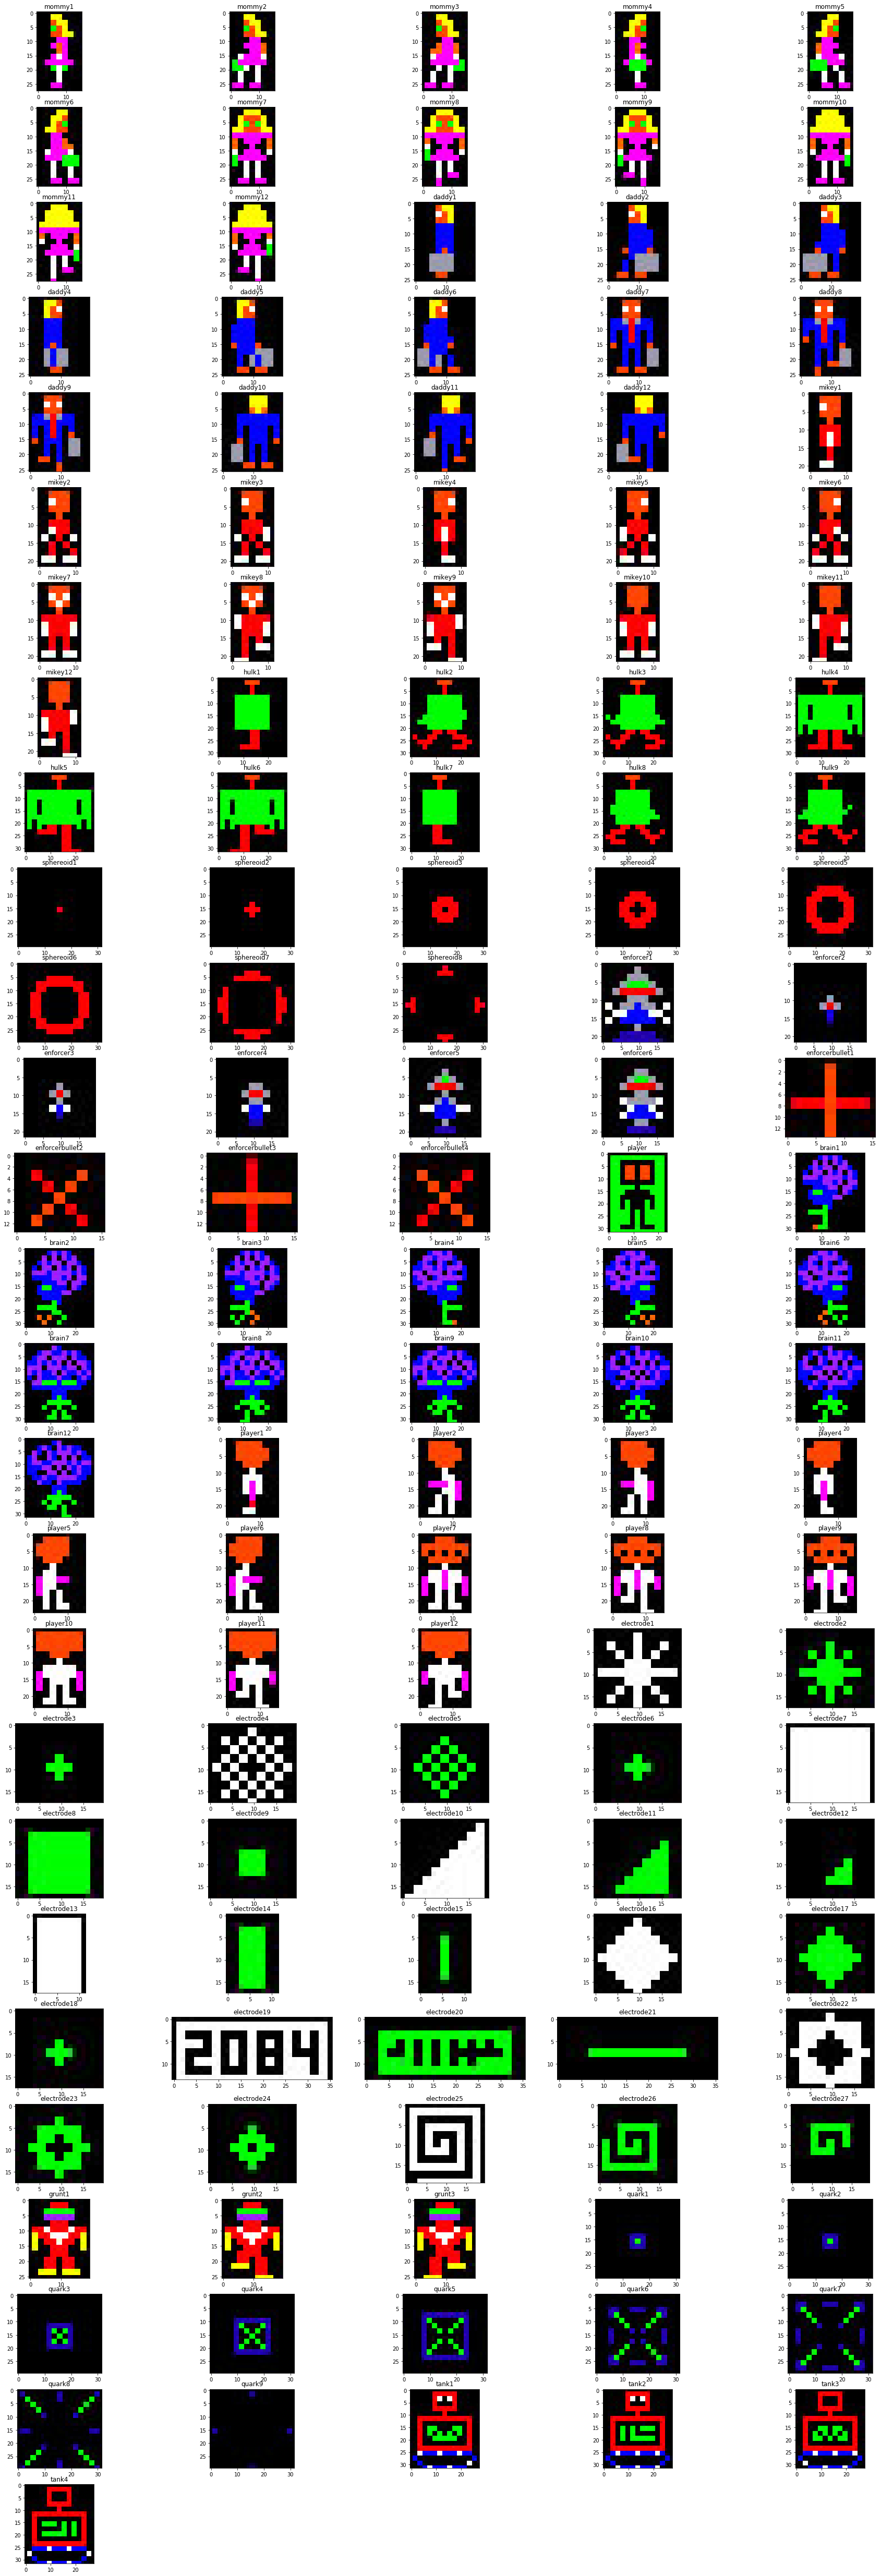

In [10]:
fig=pyplot.figure(figsize=(32, 90))
r = 5
c = int(len(X_test) / r) + 1
for i, (img, name) in enumerate(zip(X_test, X_name)):
    subplot = fig.add_subplot(c, r, i+1)
    pyplot.imshow(img)
    subplot.set_title(name)


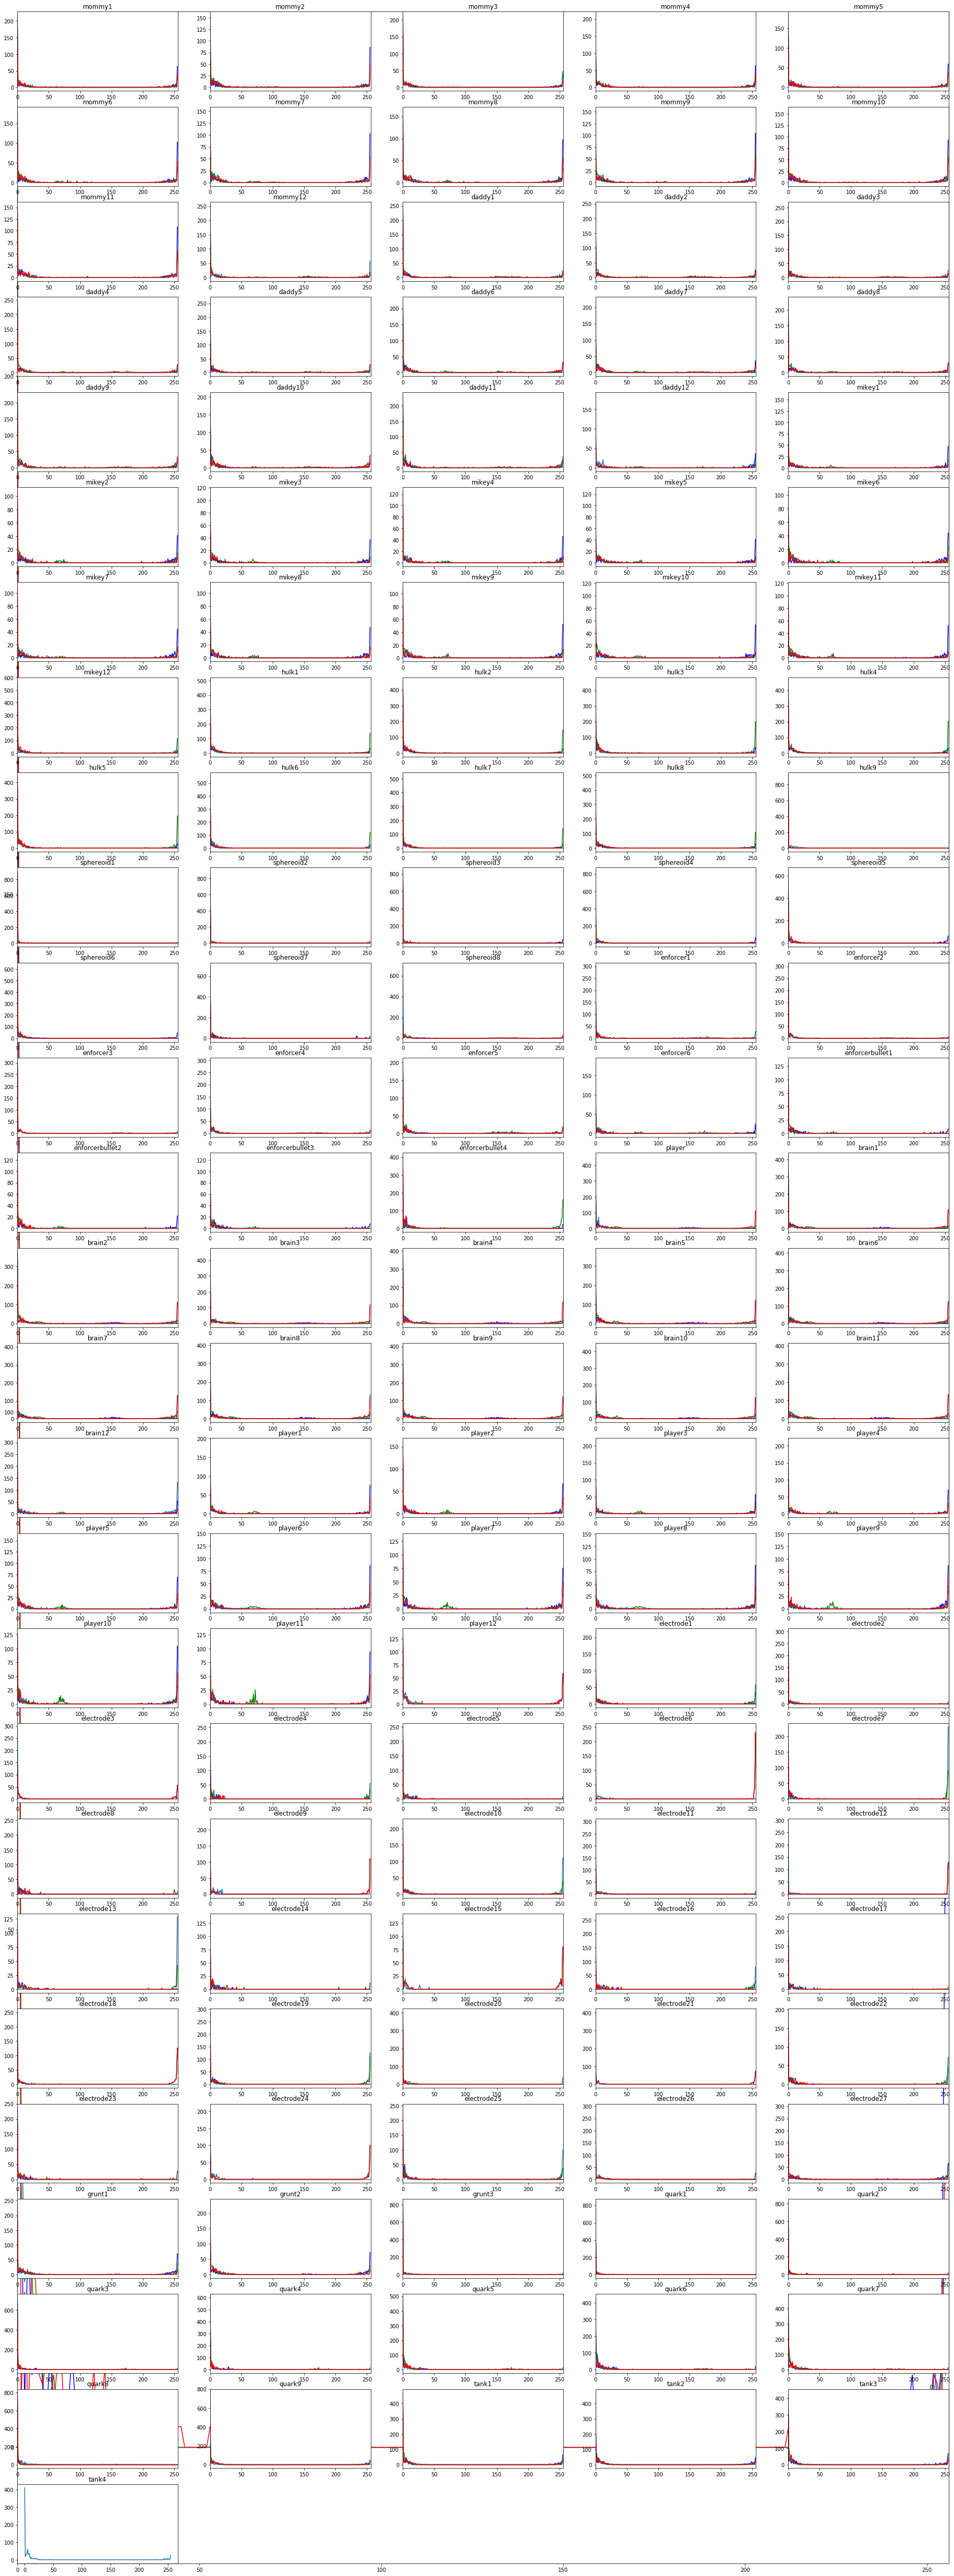

In [9]:
fig=pyplot.figure(figsize=(32, 90))
r = 5
c = int(len(X_test) / r) + 1

colors = ("b", "g", "r")
for i, (image, name) in enumerate(zip(X_test, X_name)):
    features = []
    chans = cv2.split(image)
    # loop over the image channels
    for (chan, color) in zip(chans, colors):
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)

        # plot the histogram
        pyplot.plot(hist, color = color)
        pyplot.xlim([0, 255])

    subplot = fig.add_subplot(c, r, i+1)
    pyplot.plot(hist)
    subplot.set_title(name)

In [21]:
# https://www.pyimagesearch.com/2014/01/27/hobbits-and-histograms-a-how-to-guide-to-building-your-first-image-search-engine-in-python/
import cv2
 
class RGBHistogram:
    def __init__(self, bins):
        # store the number of bins the histogram will use
        self.bins = bins

    def describe(self, image):
        # compute a 3D histogram in the RGB colorspace,
        # then normalize the histogram so that images
        # with the same content, but either scaled larger
        # or smaller will have (roughly) the same histogram
        hist = cv2.calcHist([image], [0, 1, 2], None, self.bins, [0, 256, 0, 256, 0, 256])

        hist = cv2.normalize(hist,hist)

        # return out 3D histogram as a flattened array
        return hist.flatten()

In [57]:
def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(histA, histB)])
    return d

desc = RGBHistogram([8, 8, 8])

features = []
for sprite in X_test:
    hist = desc.describe(sprite)
    features.append(hist)
    
def match(image):
    hist = desc.describe(image)
    results = []
    for name, ref_hist in zip(X_name, features):
        score = chi2_distance(hist, ref_hist)
        results.append((name, round(score, 3)))
    results = sorted(results, key=lambda score: score[1])
    return results

In [58]:
def process(frame):
    frame = cv2.resize(frame, (1280, 720))
    tagged = frame.copy()
    crop = frame[115:608, 309:975]
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,10,255,0)
    blur = cv2.GaussianBlur(thresh, (3, 3), 0)
    contours, hierarchy = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    fig=pyplot.figure(figsize=(32, 90))
    i = 0
    r = 10
    c = int(len(sprites) / 10) + 1
    for _, contour in enumerate(contours):       
        (x,y,w,h) = cv2.boundingRect(contour)
        if h < 10 or h > 415 or w < 5 or w > 145:
            continue
        i += 1
        sprite = crop[y:y+h, x:x+w]
        x += 309
        y += 115
        cv2.rectangle(tagged, (x,y), (x+w,y+h), (255, 255, 255), 2)
        guess = match(sprite)
        print("{} - {}\n".format(i, guess))
        subplot = fig.add_subplot(c, r, i)
        pyplot.imshow(sprite, cmap='gray')
        subplot.set_title("{}-{}".format(i, guess[0]))
        
        cv2.putText(tagged, "Class: {}".format(guess[0]), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    return tagged

1 - [('quark4', 0.863), ('quark8', 0.865), ('quark3', 0.866), ('quark5', 0.87), ('quark9', 0.871), ('quark2', 0.876), ('quark7', 0.876), ('quark1', 0.879), ('quark6', 0.892), ('enforcer2', 0.896), ('sphereoid1', 0.901), ('sphereoid2', 0.908), ('enforcer3', 0.922), ('electrode3', 0.926), ('electrode12', 0.929), ('electrode6', 0.932), ('electrode18', 0.932), ('sphereoid8', 0.936), ('sphereoid3', 0.942), ('electrode21', 0.943), ('enforcer4', 0.947), ('electrode15', 0.958), ('electrode9', 0.963), ('sphereoid4', 0.969), ('electrode27', 0.972), ('electrode24', 0.984), ('electrode5', 0.993), ('enforcerbullet2', 0.997), ('enforcerbullet4', 0.997), ('sphereoid7', 0.998), ('enforcer5', 1.008), ('sphereoid5', 1.012), ('electrode2', 1.031), ('electrode11', 1.033), ('enforcerbullet1', 1.039), ('enforcerbullet3', 1.039), ('sphereoid6', 1.044), ('electrode23', 1.048), ('electrode26', 1.051), ('electrode4', 1.063), ('electrode1', 1.069), ('hulk7', 1.075), ('electrode17', 1.076), ('hulk1', 1.08), ('dad

6 - [('hulk2', 0.316), ('hulk1', 0.318), ('hulk7', 0.322), ('hulk8', 0.324), ('hulk9', 0.329), ('hulk3', 0.33), ('electrode26', 0.354), ('electrode11', 0.359), ('electrode2', 0.361), ('electrode23', 0.361), ('electrode5', 0.37), ('electrode17', 0.375), ('hulk5', 0.376), ('electrode27', 0.381), ('hulk6', 0.384), ('hulk4', 0.393), ('electrode24', 0.393), ('electrode9', 0.401), ('electrode20', 0.414), ('electrode21', 0.415), ('electrode14', 0.417), ('electrode15', 0.429), ('electrode12', 0.432), ('electrode3', 0.444), ('electrode6', 0.449), ('electrode18', 0.449), ('tank4', 0.455), ('quark8', 0.457), ('tank3', 0.46), ('tank2', 0.462), ('tank1', 0.469), ('sphereoid8', 0.472), ('sphereoid3', 0.474), ('sphereoid7', 0.482), ('quark6', 0.482), ('sphereoid4', 0.487), ('sphereoid2', 0.49), ('sphereoid5', 0.496), ('quark5', 0.496), ('quark3', 0.497), ('quark4', 0.497), ('quark7', 0.497), ('electrode8', 0.501), ('enforcer3', 0.504), ('quark2', 0.507), ('quark9', 0.508), ('quark1', 0.509), ('sphere

10 - [('quark3', 0.174), ('quark9', 0.175), ('quark2', 0.178), ('quark1', 0.179), ('quark8', 0.179), ('quark4', 0.186), ('sphereoid1', 0.192), ('enforcer2', 0.198), ('quark5', 0.2), ('sphereoid2', 0.204), ('quark7', 0.207), ('quark6', 0.209), ('enforcer3', 0.222), ('sphereoid8', 0.223), ('electrode3', 0.223), ('electrode12', 0.228), ('electrode6', 0.229), ('electrode18', 0.229), ('sphereoid3', 0.236), ('electrode21', 0.241), ('enforcer4', 0.249), ('electrode15', 0.256), ('electrode9', 0.263), ('electrode27', 0.267), ('sphereoid4', 0.27), ('electrode24', 0.285), ('enforcerbullet2', 0.287), ('enforcerbullet4', 0.287), ('sphereoid7', 0.288), ('electrode5', 0.3), ('sphereoid5', 0.311), ('enforcer5', 0.313), ('enforcerbullet1', 0.331), ('sphereoid6', 0.341), ('enforcerbullet3', 0.343), ('electrode11', 0.347), ('electrode2', 0.349), ('electrode26', 0.368), ('electrode23', 0.371), ('hulk7', 0.384), ('daddy1', 0.386), ('daddy4', 0.388), ('hulk1', 0.389), ('enforcer6', 0.39), ('electrode17', 0.

14 - [('sphereoid5', 0.469), ('sphereoid6', 0.469), ('sphereoid7', 0.474), ('sphereoid4', 0.507), ('sphereoid3', 0.528), ('sphereoid8', 0.537), ('grunt1', 0.548), ('tank3', 0.553), ('tank4', 0.554), ('enforcerbullet1', 0.556), ('enforcerbullet2', 0.557), ('enforcerbullet4', 0.557), ('grunt2', 0.562), ('tank2', 0.567), ('enforcerbullet3', 0.568), ('grunt3', 0.569), ('tank1', 0.569), ('sphereoid2', 0.584), ('sphereoid1', 0.609), ('electrode3', 0.623), ('electrode6', 0.623), ('electrode18', 0.623), ('quark9', 0.625), ('quark1', 0.627), ('mikey4', 0.628), ('enforcer2', 0.628), ('quark2', 0.628), ('electrode12', 0.631), ('electrode21', 0.636), ('enforcer3', 0.638), ('electrode15', 0.646), ('hulk2', 0.648), ('quark3', 0.649), ('electrode9', 0.652), ('hulk8', 0.656), ('electrode27', 0.656), ('quark8', 0.656), ('enforcer4', 0.657), ('hulk9', 0.658), ('mikey1', 0.659), ('hulk1', 0.663), ('hulk3', 0.664), ('hulk7', 0.665), ('mikey11', 0.67), ('mikey12', 0.674), ('electrode24', 0.674), ('mikey2',

18 - [('hulk7', 0.289), ('hulk1', 0.293), ('hulk2', 0.301), ('hulk8', 0.305), ('electrode5', 0.31), ('hulk3', 0.312), ('hulk9', 0.317), ('electrode11', 0.318), ('electrode17', 0.319), ('electrode26', 0.32), ('electrode2', 0.321), ('electrode27', 0.321), ('electrode23', 0.322), ('electrode21', 0.342), ('electrode24', 0.343), ('electrode9', 0.347), ('electrode12', 0.358), ('quark8', 0.366), ('electrode3', 0.368), ('hulk5', 0.371), ('electrode15', 0.371), ('hulk6', 0.386), ('electrode6', 0.387), ('electrode18', 0.387), ('electrode14', 0.394), ('electrode20', 0.396), ('quark4', 0.402), ('quark6', 0.403), ('sphereoid8', 0.404), ('quark5', 0.404), ('hulk4', 0.406), ('quark3', 0.409), ('quark7', 0.41), ('sphereoid2', 0.415), ('sphereoid3', 0.415), ('quark2', 0.421), ('quark1', 0.423), ('sphereoid7', 0.425), ('tank4', 0.426), ('quark9', 0.428), ('sphereoid1', 0.43), ('enforcer3', 0.431), ('tank3', 0.432), ('enforcer2', 0.434), ('enforcerbullet2', 0.435), ('enforcerbullet4', 0.435), ('tank2', 0

22 - [('enforcer3', 0.31), ('quark9', 0.318), ('quark2', 0.319), ('quark1', 0.323), ('enforcer2', 0.327), ('quark3', 0.33), ('sphereoid1', 0.337), ('enforcer4', 0.338), ('sphereoid2', 0.343), ('quark8', 0.346), ('quark4', 0.35), ('electrode3', 0.362), ('electrode12', 0.365), ('electrode6', 0.368), ('electrode18', 0.368), ('quark6', 0.369), ('sphereoid8', 0.372), ('quark5', 0.373), ('quark7', 0.373), ('sphereoid3', 0.379), ('electrode21', 0.38), ('enforcer5', 0.39), ('electrode15', 0.395), ('electrode9', 0.402), ('electrode27', 0.408), ('sphereoid4', 0.409), ('electrode24', 0.424), ('enforcerbullet2', 0.435), ('enforcerbullet4', 0.435), ('electrode5', 0.438), ('sphereoid7', 0.44), ('enforcer6', 0.444), ('sphereoid5', 0.459), ('daddy1', 0.466), ('electrode2', 0.476), ('enforcerbullet1', 0.481), ('enforcerbullet3', 0.481), ('electrode11', 0.481), ('daddy4', 0.483), ('electrode4', 0.488), ('sphereoid6', 0.496), ('electrode1', 0.497), ('mommy1', 0.505), ('electrode26', 0.507), ('electrode23

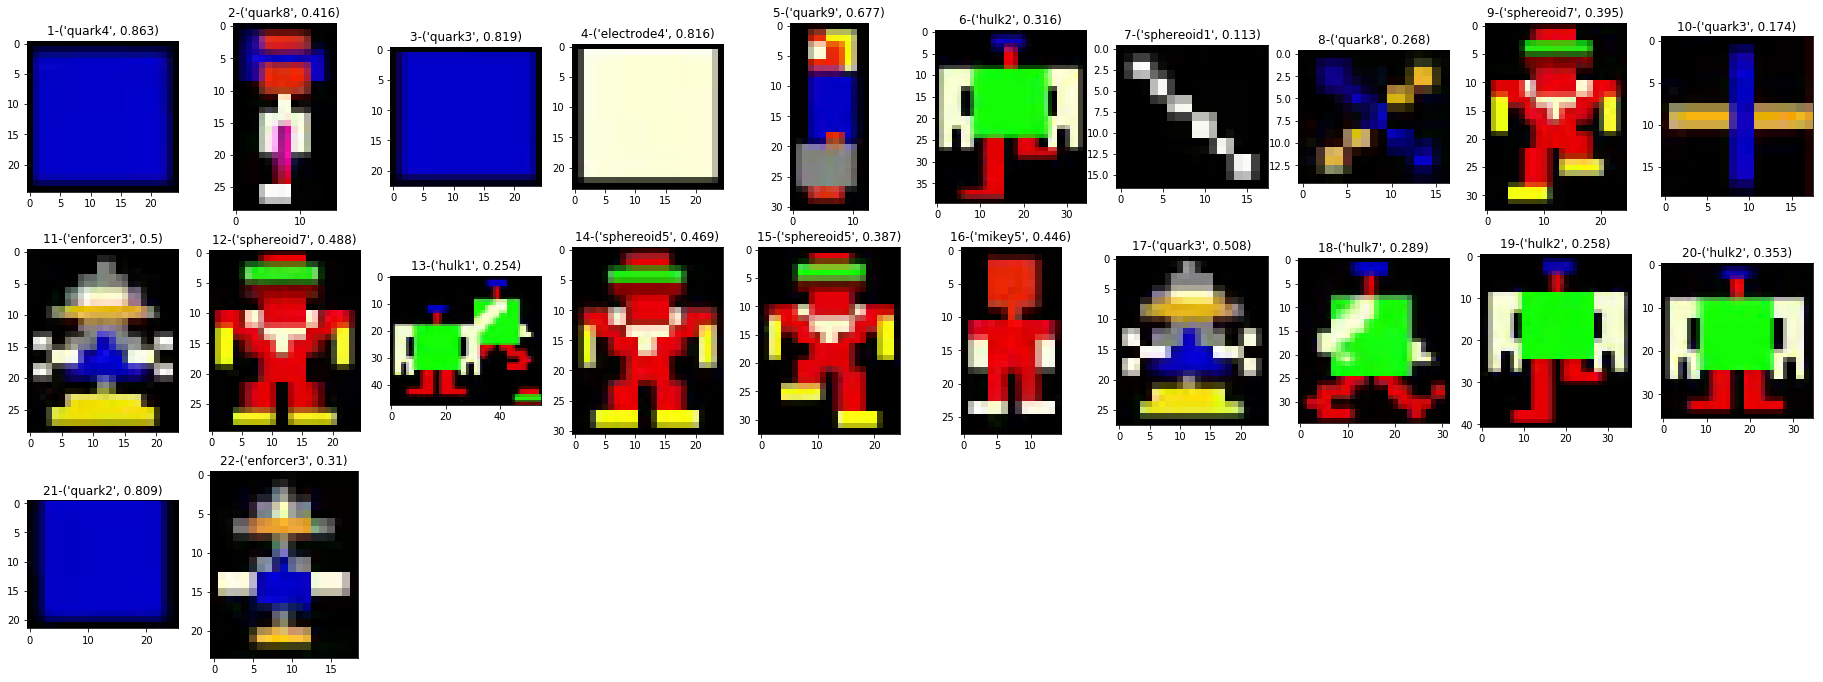

In [59]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('/home/strider/Code/robotron/resources/video/robotron-1.mp4')
img = clip.get_frame(101.6)
pyplot.rcParams['figure.figsize'] = [24, 16]
im = process(img)

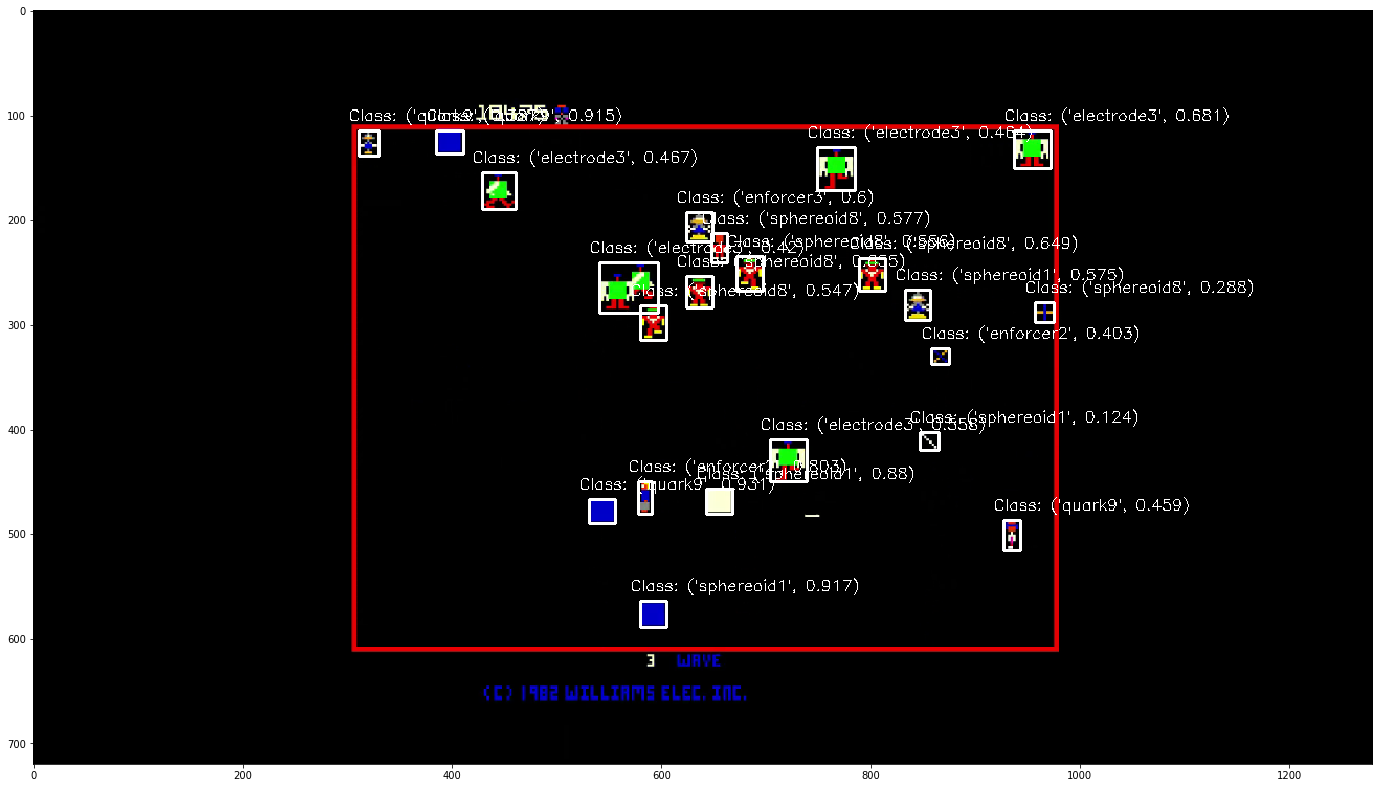

In [50]:
pyplot.imshow(im)